# Computer Vision - Assignment 2
### Harshavardhan P
### 2021111003

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import tqdm
import torch.nn as nn
import wandb
from scipy.cluster.vq import kmeans, vq
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42)
torch.manual_seed(42)
torch.random.manual_seed(42)

## Q1: SIFT-BoVW-SVM

### 1.1

#### Dataset

In [3]:
# importing the MNIST dataset
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transforms.ToTensor())
testset = datasets.MNIST('mnist', download=True, train=False, transform=transforms.ToTensor())

print("Number of training examples: ", len(trainset))
print("Number of testing examples: ", len(testset))

Number of training examples:  60000
Number of testing examples:  10000


#### Testing process on 100 samples

In [4]:
sift = cv2.SIFT_create()
keypoints = []
descriptors = []
for i in range(100):
    img = trainset[i][0].numpy().squeeze() * 255
    img = img.astype(np.uint8)
    kp, des = sift.detectAndCompute(img, None)
    keypoints.append(kp)
    descriptors.append(des)

print("Number of keypoints: ", len(keypoints))
print("Number of descriptors: ", len(descriptors))

Number of keypoints:  100
Number of descriptors:  100


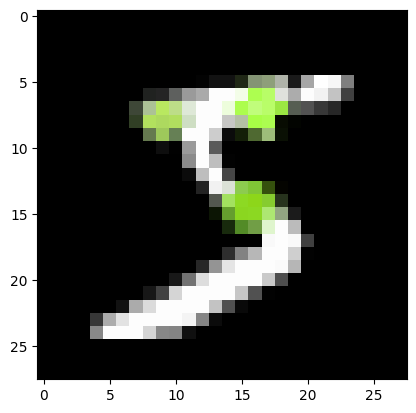

In [167]:
# drawing the keypoints
img = trainset[0][0].numpy().squeeze() * 255
img = img.astype(np.uint8)
img = cv2.drawKeypoints(img, keypoints[0], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()

In [168]:
des = []
for des_ in descriptors:
    if des_ is not None:
        for d in des_:
            des.append(d)
des = np.stack(des, axis=0)
print("Descriptors shape: ", des.shape)

Descriptors shape:  (757, 128)


In [169]:
codebook, distortion = kmeans(des, 20, 100)

In [170]:
# quantizing the descriptors to get the visual words
words = []
for d in descriptors:
    if d is not None:
        code, dist = vq(d, codebook)
        words.append(code)

In [171]:
# creating the frequency vectors
freq_vecs = []
for word in words:
    freq_vec = np.zeros(20)
    for w in word:
        freq_vec[w] += 1
    freq_vecs.append(freq_vec)

freq_vecs = np.stack(freq_vecs, axis=0)
print("Frequency vectors shape: ", freq_vecs.shape)

Frequency vectors shape:  (98, 20)


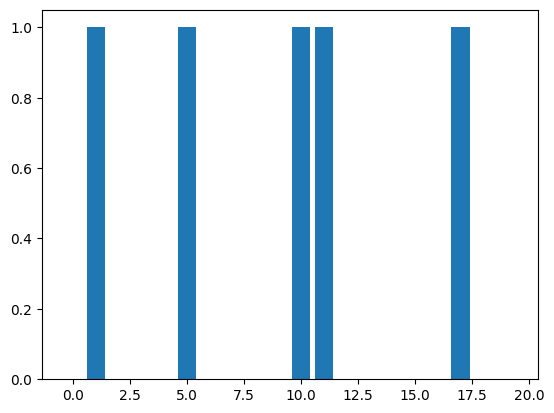

In [172]:
plt.bar(range(20), freq_vecs[0])
plt.show()

#### SIFT for MNIST

In [173]:
# SIFT keypoints and descriptors for entire MNIST dataset
mnist_keypoints = []
mnist_descriptors = []
for i in range(len(trainset)):
    img = trainset[i][0].numpy().squeeze() * 255
    img = img.astype(np.uint8)
    kp, des = sift.detectAndCompute(img, None)
    mnist_keypoints.append(kp)
    mnist_descriptors.append(des if des is not None else np.zeros((1, 128)))

In [174]:
# getting all the descriptors in a single array
final_des = []
for des in mnist_descriptors:
    if des is not None:
        for d in des:
            final_des.append(d)
final_des = np.stack(final_des, axis=0)
print("Final descriptors shape: ", final_des.shape)

Final descriptors shape:  (470877, 128)


In [175]:
# getting the codebook for the entire dataset
codebook, distortion = kmeans(final_des, 15, 2)

In [176]:
# getting the visual words for the entire dataset
mnist_words = []
for d in mnist_descriptors:
    if d is not None:
        code, dist = vq(d, codebook)
        mnist_words.append(code)

In [177]:
# getting the frequency vectors for the entire dataset
freq_vecs = []
for word in mnist_words:
    freq_vec = np.zeros(15)
    for w in word:
        freq_vec[w] += 1
    freq_vecs.append(freq_vec)

freq_vecs = np.stack(freq_vecs, axis=0)
print("Frequency vectors shape: ", freq_vecs.shape)

Frequency vectors shape:  (60000, 15)


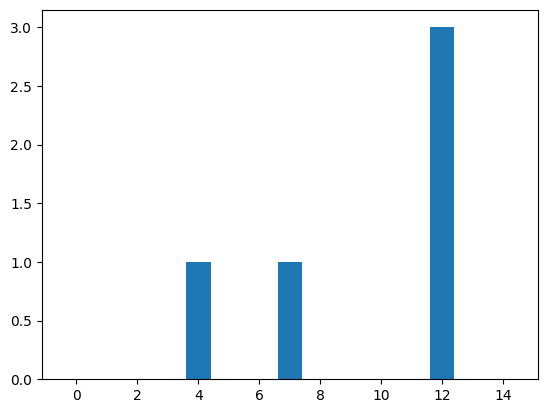

In [178]:
# plotting the frequency vectors
plt.bar(range(15), freq_vecs[0])
plt.show()

In [183]:
# splitting the dataset into training and testing
x_train, X_test, y_train, y_test = train_test_split(freq_vecs, trainset.targets.numpy(), test_size=0.2, random_state=42)

# training a SVM model
model = SVC(kernel='linear', C=1, gamma='auto', random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# training a linear SVM model
model = LinearSVC(C=1, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.462


/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.43266666666666664


/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### 1.2

In [184]:
# testing the method with variation in the number of clusters
results = {}
for k in [1, 2, 5, 10, 20, 50, 100]:
    codebook, distortion = kmeans(final_des, k, 2)

    mnist_words = []
    for d in mnist_descriptors:
        if d is not None:
            code, dist = vq(d, codebook)
            mnist_words.append(code)

    freq_vecs = []
    for word in mnist_words:
        freq_vec = np.zeros(k)
        for w in word:
            freq_vec[w] += 1
        freq_vecs.append(freq_vec)
    freq_vecs = np.stack(freq_vecs, axis=0)

    x_train, X_test, y_train, y_test = train_test_split(freq_vecs, trainset.targets.numpy(), test_size=0.2, random_state=42)
    model = LinearSVC(C=1, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy for k = {}: {}".format(k, accuracy))

    results[k] = accuracy

/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for k = 1: 0.18425


/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for k = 2: 0.19658333333333333


/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for k = 5: 0.34225


/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for k = 10: 0.38908333333333334


/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for k = 20: 0.5011666666666666


/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for k = 50: 0.6366666666666667


/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy for k = 100: 0.72875


/Users/harshavardhan/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


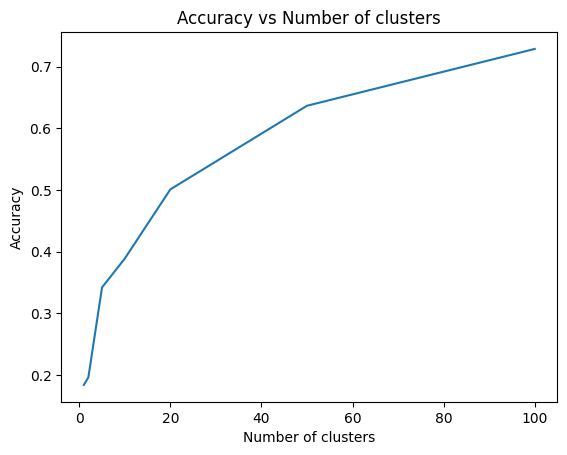

In [185]:
# plotting the results
plt.plot(list(results.keys()), list(results.values()))
plt.title('Accuracy vs Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy')
plt.show()

- The SIFT-BoVW-SVM classifier performs better on increasing the number of clusters because the number of clusters is directly proportional to the number of visual words. The number of visual words is directly proportional to the number of features that are being extracted from the image. The more the number of features, the more the information that is being extracted from the image. This information is then used to train the SVM model. The more the information, the better the model is trained and the better the model performs on the test data.

### 1.3

In [11]:
# hyperparameter checking
params = [
    [dict(nOctaveLayers=2), dict(random_state=42, kernel='linear'), 'normal'],
    [dict(nOctaveLayers=2), dict(random_state=42, kernel='sigmoid'), 'normal'],
    [dict(nOctaveLayers=3), dict(random_state=42, kernel='linear'), 'normal'],
    [dict(nOctaveLayers=3), dict(random_state=42, kernel='sigmoid'), 'normal'],
    [dict(nOctaveLayers=4), dict(random_state=42, kernel='linear'), 'normal'],
    [dict(nOctaveLayers=4), dict(random_state=42, kernel='sigmoid'), 'normal']
]

results = {}
for param in params:
    # opening the parameters
    sift_params, svm_params, svm_type = param

    # creating the SIFT object
    sift = cv2.SIFT_create(**sift_params)
    mnist_keypoints = []
    mnist_descriptors = []
    for i in range(len(trainset)):
        img = trainset[i][0].numpy().squeeze() * 255
        img = img.astype(np.uint8)
        kp, des = sift.detectAndCompute(img, None)
        mnist_keypoints.append(kp)
        mnist_descriptors.append(des if des is not None else np.zeros((1, 128)))

    # getting all the descriptors in a single array
    final_des = []
    for des in mnist_descriptors:
        if des is not None:
            for d in des:
                final_des.append(d)
    final_des = np.stack(final_des, axis=0)

    # generating the codebook
    codebook, distortion = kmeans(final_des, 15, 2)

    # getting the visual words for the entire dataset
    mnist_words = []
    for d in mnist_descriptors:
        if d is not None:
            code, dist = vq(d, codebook)
            mnist_words.append(code)
    freq_vecs = []

    # getting the frequency vectors for the entire dataset
    for word in mnist_words:
        freq_vec = np.zeros(15)
        for w in word:
            freq_vec[w] += 1
        freq_vecs.append(freq_vec)
    freq_vecs = np.stack(freq_vecs, axis=0)

    # splitting the dataset into training and testing
    x_train, X_test, y_train, y_test = train_test_split(freq_vecs, trainset.targets.numpy(), test_size=0.2, random_state=42)
    if svm_type == 'normal':
        model = SVC(**svm_params)
    else:
        model = LinearSVC(**svm_params)
    model.fit(x_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy for {}: {}".format(svm_params, accuracy))

    # saving the results
    results[str(param)] = accuracy

Accuracy for {'random_state': 42, 'kernel': 'linear'}: 0.4771666666666667
Accuracy for {'random_state': 42, 'kernel': 'sigmoid'}: 0.2708333333333333
Accuracy for {'random_state': 42, 'kernel': 'linear'}: 0.46375
Accuracy for {'random_state': 42, 'kernel': 'sigmoid'}: 0.23466666666666666
Accuracy for {'random_state': 42, 'kernel': 'linear'}: 0.5095833333333334
Accuracy for {'random_state': 42, 'kernel': 'sigmoid'}: 0.25075


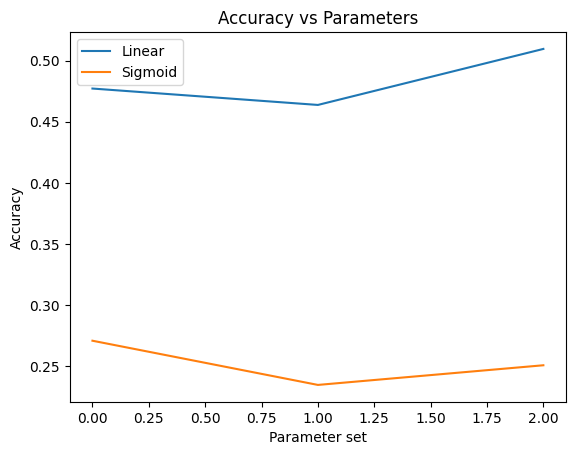

In [12]:
# plotting the results
params = list(results.keys())
params = [eval(p) for p in params]
accuracy = list(results.values())
linear_acc = [acc for param, acc in zip(params, accuracy) if param[1]['kernel'] == 'linear']
sigmoid_acc = [acc for param, acc in zip(params, accuracy) if param[1]['kernel'] == 'sigmoid']

plt.plot(range(len(linear_acc)), linear_acc, label='Linear')
plt.plot(range(len(sigmoid_acc)), sigmoid_acc, label='Sigmoid')
plt.title('Accuracy vs Parameters')
plt.xlabel('Parameter set')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- All the testing here is done using only 15 clusters  obtained with iteration of 2 and so are not high performing models. However, we can expect similar trends to be observed in the high performing models as well.

- The number of octave layers influences the SIFT class by changing the number of features that are being extracted from the image. The more the number of features, the more the information that is being extracted from the image. This information is then used to train the SVM model. The more the information, the better the model is trained and the better the model performs on the test data.
- However, the number of octave layers also increases the time taken to extract the features from the image. This is because the number of features that are being extracted from the image is directly proportional to the number of octave layers. The more the number of features, the more the time taken to extract the features from the image.

- The kernel function changes the SVM model by changing the way the data is being classified. The kernel function is used to map the data to a higher dimension so that the data can be classified more easily. Linear kernel function is used to classify the data when the data is linearly separable. Sigmoid kernel function is used to classify the data when the data is not linearly separable. Polynomial kernel function is used to classify the data when the data is not linearly separable and the degree of the polynomial is used to classify the data.
- In this case, sigmoid kernel performs much worse compared to the linear kernel, and we can expect the polynomial kernel to perform closer to the linear kernel, as polynomial can be used to classify non-linearly separable data as well as linear data.

## Q2: CNNs and Transformers

### 2.1

#### CNN

In [2]:
# building the LeNet CNN model for predicting the MNIST dataset
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = torch.nn.Linear(16*5*5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16*5*5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Vision Transformer Encoder

In [3]:
class ViT(nn.Module):
    def __init__(self, input_size, patch_size, hidden_dim, num_heads, num_layers):
        super().__init__()
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.num_patches = int(input_size[0] * input_size[1] / (self.patch_size ** 2))
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))

        self.patch2vec = nn.Conv2d(1, hidden_dim, kernel_size=self.patch_size, stride=self.patch_size)
        self.pos_embeddings = nn.Parameter(torch.randn(1, self.num_patches, self.hidden_dim))
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dim_feedforward=2*hidden_dim, batch_first=True), num_layers=num_layers)
        self.classifier = nn.Linear(hidden_dim, 10)

    def embed(self, x):
        x = self.patch2vec(x).reshape(x.shape[0], self.hidden_dim, -1)
        x = x.permute(0, 2, 1) + self.pos_embeddings
        x = torch.cat([self.cls_token + torch.zeros(x.shape[0], 1, 1), x], 1)
        return x

    def forward(self, x):
        x = self.embed(x)
        x = self.encoder(x)
        x = self.classifier(x[:, 0])
        return x

#### Trainer

In [53]:
class Classifier:
    def __init__(self, logging=False):
        self.logging = logging
        if self.logging:
            wandb.init(project='mnist-classification', entity='rockingharsha71')
            self.config = wandb.config

    # data processing (dataset and dataloaders)
    def prepare_data(self, batch_size=64, shuffle=True, transform=None, train_size=60000):
        if transform is None:
            transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        self.trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
        self.testset = datasets.MNIST('mnist', download=True, train=False, transform=transform)
        if train_size < 60000:
            # split the dataset such that the class distribution is maintained
            classes_count = np.zeros(10)
            trainset = []
            testset = []
            for i in range(len(self.trainset)):
                if classes_count[self.trainset[i][1]] < train_size / 10:
                    trainset.append(self.trainset[i])
                    classes_count[self.trainset[i][1]] += 1
            self.trainset = trainset
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=64, shuffle=shuffle)
        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=64, shuffle=shuffle)
        if self.logging:
            self.config.batch_size = batch_size
            self.config.dataset = 'MNIST'

    # model creation and setup
    def create_model(self, model, optimizer, criterion, lr=0.001, weight_decay=0.0001):
        torch.manual_seed(42)
        torch.random.manual_seed(42)
        # self.model = LeNet()
        # self.model = ViT((28, 28), 4, 100, 4, 2)
        self.model = model
        self.optimizer = optimizer(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.criterion = criterion()

        if self.logging:
            if self.optimizer.__class__.__name__ == 'Adam':
                self.config.optimizer = 'Adam'
            elif self.optimizer.__class__.__name__ == 'SGD':
                self.config.optimizer = 'SGD'
            self.config.lr = lr
            self.config.weight_decay = weight_decay
            if self.model.__class__.__name__ == 'LeNet':
                self.config.model = 'LeNet'
            elif self.model.__class__.__name__ == 'ViT':
                self.config.model = 'ViT'
                self.config.patch_size = 4
                self.config.hidden_dim = 100
                self.config.num_heads = 4
                self.config.num_layers = 2
            if self.criterion.__class__.__name__ == 'CrossEntropyLoss':
                self.config.criterion = 'CrossEntropyLoss'
            elif self.criterion.__class__.__name__ == 'MSELoss':
                self.config.criterion = 'MSELoss'
            elif self.criterion.__class__.__name__ == 'NLLLoss':
                self.config.criterion = 'NLLLoss'
            self.config.num_epochs = 5

    # training and evaluation
    def train(self):
        self.train_losses = []
        self.train_counter = []

        self.model.train()
        pbar = tqdm.tqdm(self.trainloader)
        acc = 0
        total_loss = 0
        len_targets = 0
        for batch_idx, (data, target) in enumerate(pbar):
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()
            pbar.set_description(desc= 'loss={:.4f}'.format(loss.item()))
            self.train_losses.append(loss.item() / 64)
            self.train_counter.append(
                (batch_idx*64) + ((self.n_epochs-1)*len(self.trainloader.dataset)))
            for i in range(len(target)):
                if target[i] == torch.argmax(output[i]):
                    acc += 1
            total_loss += loss.item()
            len_targets += len(target)
        acc = acc / len_targets
        total_loss = total_loss / len_targets
        if self.logging:
            wandb.log({'train_loss': total_loss / 64, 'train_accuracy': acc})
        return acc, total_loss

    def evaluate(self):
        self.test_losses = []
        self.test_counter = [i*len(self.trainloader.dataset) for i in range(1, self.n_epochs + 1)]

        self.model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in self.testloader:
                output = self.model(data)
                test_loss += self.criterion(output, target).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(self.testloader.dataset)
        self.test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(self.testloader.dataset),
            100. * correct / len(self.testloader.dataset)))
        if self.logging:
            wandb.log({'test_loss': test_loss, 'test_accuracy': correct / len(self.testloader.dataset)})
        return correct / len(self.testloader.dataset), test_loss

    def train_model(self, n_epochs=5):
        self.n_epochs = n_epochs
        train_accuracy, test_accuracy = 0, 0
        train_loss, test_loss = 0, 0
        for epoch in range(1, n_epochs + 1):
            train_accuracy, train_loss = self.train()
            test_accuracy, test_loss = self.evaluate()

        if self.logging:
            wandb.finish()

        return train_accuracy, train_loss, test_accuracy, test_loss

    # prediction
    def predict(self, image):
        image = cv2.resize(image, (28, 28))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image / 255.0
        image = image.reshape(1, 1, 28, 28)
        image = torch.tensor(image, dtype=torch.float32)
        output = self.model(image)
        _, predicted = torch.max(output.data, 1)
        return predicted.item()

In [62]:
classifier = Classifier(logging=True)
classifier.prepare_data(shuffle=False)
classifier.create_model(model=LeNet(), optimizer=torch.optim.Adam, criterion=nn.CrossEntropyLoss)
classifier.train_model(n_epochs=5)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rockingharsha71. Use `wandb login --relogin` to force relogin


loss=0.0349: 100%|██████████| 938/938 [00:14<00:00, 64.46it/s]



Test set: Avg. loss: 0.0017, Accuracy: 9651/10000 (97%)



loss=0.0055: 100%|██████████| 938/938 [00:13<00:00, 68.25it/s]



Test set: Avg. loss: 0.0009, Accuracy: 9824/10000 (98%)



loss=0.0015: 100%|██████████| 938/938 [00:13<00:00, 68.20it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9853/10000 (99%)



loss=0.0042: 100%|██████████| 938/938 [00:13<00:00, 71.51it/s]



Test set: Avg. loss: 0.0006, Accuracy: 9866/10000 (99%)



loss=0.0005: 100%|██████████| 938/938 [00:13<00:00, 68.11it/s]



Test set: Avg. loss: 0.0006, Accuracy: 9878/10000 (99%)



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test_accuracy,▁▆▇██
test_loss,█▃▂▁▁
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
test_accuracy,0.9878
test_loss,0.00057
train_accuracy,0.98883
train_loss,1e-05


(0.9888333333333333,
 0.0005753606732807384,
 tensor(0.9878),
 0.0005731480974138321)

The sample run can be found [here](https://wandb.ai/rockingharsha71/mnist-classification?nw=nwuserrockingharsha71)

### 2.2

#### Influence of Learning Rate

In [14]:
# testing with different learning rates
results = {}
for lr in [0.01, 0.001, 0.0001]:
    classifier = Classifier()
    classifier.prepare_data(shuffle=False)
    classifier.create_model(model=LeNet(), optimizer=torch.optim.Adam, criterion=nn.CrossEntropyLoss, lr=lr)
    train_accuracy, train_loss, test_accuracy, test_loss = classifier.train_model(n_epochs=5)
    results[str(lr)] = {'train_accuracy': train_accuracy, 'train_loss': train_loss, 'test_accuracy': test_accuracy, 'test_loss': test_loss}

loss=0.0430: 100%|██████████| 938/938 [00:13<00:00, 69.69it/s]



Test set: Avg. loss: 0.0021, Accuracy: 9617/10000 (96%)



loss=0.0011: 100%|██████████| 938/938 [00:13<00:00, 68.17it/s]



Test set: Avg. loss: 0.0016, Accuracy: 9709/10000 (97%)



loss=0.0364: 100%|██████████| 938/938 [00:13<00:00, 71.60it/s]



Test set: Avg. loss: 0.0030, Accuracy: 9529/10000 (95%)



loss=0.0102: 100%|██████████| 938/938 [00:12<00:00, 72.96it/s]



Test set: Avg. loss: 0.0015, Accuracy: 9744/10000 (97%)



loss=0.0136: 100%|██████████| 938/938 [00:13<00:00, 70.50it/s]



Test set: Avg. loss: 0.0012, Accuracy: 9803/10000 (98%)



loss=0.0150: 100%|██████████| 938/938 [00:13<00:00, 68.36it/s]



Test set: Avg. loss: 0.0014, Accuracy: 9724/10000 (97%)



loss=0.0088: 100%|██████████| 938/938 [00:13<00:00, 68.24it/s]



Test set: Avg. loss: 0.0009, Accuracy: 9824/10000 (98%)



loss=0.0044: 100%|██████████| 938/938 [00:14<00:00, 66.99it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9863/10000 (99%)



loss=0.0020: 100%|██████████| 938/938 [00:13<00:00, 67.93it/s]



Test set: Avg. loss: 0.0006, Accuracy: 9875/10000 (99%)



loss=0.0010: 100%|██████████| 938/938 [00:14<00:00, 63.93it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9850/10000 (98%)



loss=0.3032: 100%|██████████| 938/938 [00:15<00:00, 61.04it/s]



Test set: Avg. loss: 0.0054, Accuracy: 9025/10000 (90%)



loss=0.1285: 100%|██████████| 938/938 [00:16<00:00, 58.43it/s]



Test set: Avg. loss: 0.0033, Accuracy: 9376/10000 (94%)



loss=0.0491: 100%|██████████| 938/938 [00:17<00:00, 53.27it/s]



Test set: Avg. loss: 0.0023, Accuracy: 9538/10000 (95%)



loss=0.0279: 100%|██████████| 938/938 [00:18<00:00, 50.80it/s]



Test set: Avg. loss: 0.0018, Accuracy: 9646/10000 (96%)



loss=0.0199: 100%|██████████| 938/938 [00:17<00:00, 53.40it/s]



Test set: Avg. loss: 0.0014, Accuracy: 9710/10000 (97%)



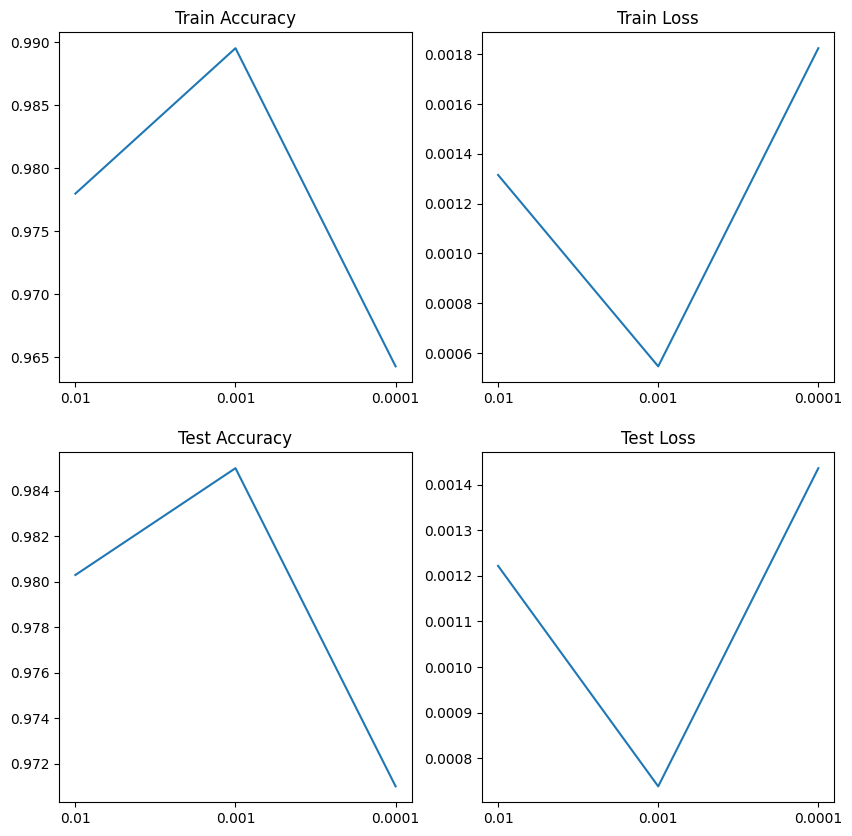

In [15]:
# plotting the results from the lr
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# plotting the train accuracy
axs[0, 0].plot(list(results.keys()), [results[lr]['train_accuracy'] for lr in results.keys()])
axs[0, 0].set_title('Train Accuracy')
# plotting the train loss
axs[0, 1].plot(list(results.keys()), [results[lr]['train_loss'] for lr in results.keys()])
axs[0, 1].set_title('Train Loss')
# plotting the test accuracy
axs[1, 0].plot(list(results.keys()), [results[lr]['test_accuracy'] for lr in results.keys()])
axs[1, 0].set_title('Test Accuracy')
# plotting the test loss
axs[1, 1].plot(list(results.keys()), [results[lr]['test_loss'] for lr in results.keys()])
axs[1, 1].set_title('Test Loss')
plt.show()

#### Influence of Batch Size

In [17]:
# testing with different batch sizes
results = {}
for batch_size in [32, 64, 128]:
    classifier = Classifier()
    classifier.prepare_data(shuffle=False, batch_size=batch_size)
    classifier.create_model(model=LeNet(), optimizer=torch.optim.Adam, criterion=nn.CrossEntropyLoss)
    train_accuracy, train_loss, test_accuracy, test_loss = classifier.train_model(n_epochs=5)
    results[str(batch_size)] = {'train_accuracy': train_accuracy, 'train_loss': train_loss, 'test_accuracy': test_accuracy, 'test_loss': test_loss}

loss=0.0150: 100%|██████████| 938/938 [00:13<00:00, 68.08it/s]



Test set: Avg. loss: 0.0014, Accuracy: 9724/10000 (97%)



loss=0.0088: 100%|██████████| 938/938 [00:13<00:00, 67.92it/s]



Test set: Avg. loss: 0.0009, Accuracy: 9824/10000 (98%)



loss=0.0044: 100%|██████████| 938/938 [00:13<00:00, 68.29it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9863/10000 (99%)



loss=0.0020: 100%|██████████| 938/938 [00:13<00:00, 67.21it/s]



Test set: Avg. loss: 0.0006, Accuracy: 9875/10000 (99%)



loss=0.0010: 100%|██████████| 938/938 [00:14<00:00, 65.43it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9850/10000 (98%)



loss=0.0150: 100%|██████████| 938/938 [00:14<00:00, 65.80it/s]



Test set: Avg. loss: 0.0014, Accuracy: 9724/10000 (97%)



loss=0.0088: 100%|██████████| 938/938 [00:14<00:00, 64.34it/s]



Test set: Avg. loss: 0.0009, Accuracy: 9824/10000 (98%)



loss=0.0044: 100%|██████████| 938/938 [00:15<00:00, 61.66it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9863/10000 (99%)



loss=0.0020: 100%|██████████| 938/938 [00:16<00:00, 56.47it/s]



Test set: Avg. loss: 0.0006, Accuracy: 9875/10000 (99%)



loss=0.0010: 100%|██████████| 938/938 [00:18<00:00, 52.04it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9850/10000 (98%)



loss=0.0150: 100%|██████████| 938/938 [00:20<00:00, 46.14it/s]



Test set: Avg. loss: 0.0014, Accuracy: 9724/10000 (97%)



loss=0.0088: 100%|██████████| 938/938 [00:19<00:00, 46.96it/s]



Test set: Avg. loss: 0.0009, Accuracy: 9824/10000 (98%)



loss=0.0044: 100%|██████████| 938/938 [00:18<00:00, 49.98it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9863/10000 (99%)



loss=0.0020: 100%|██████████| 938/938 [00:18<00:00, 50.33it/s]



Test set: Avg. loss: 0.0006, Accuracy: 9875/10000 (99%)



loss=0.0010: 100%|██████████| 938/938 [00:19<00:00, 48.31it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9850/10000 (98%)



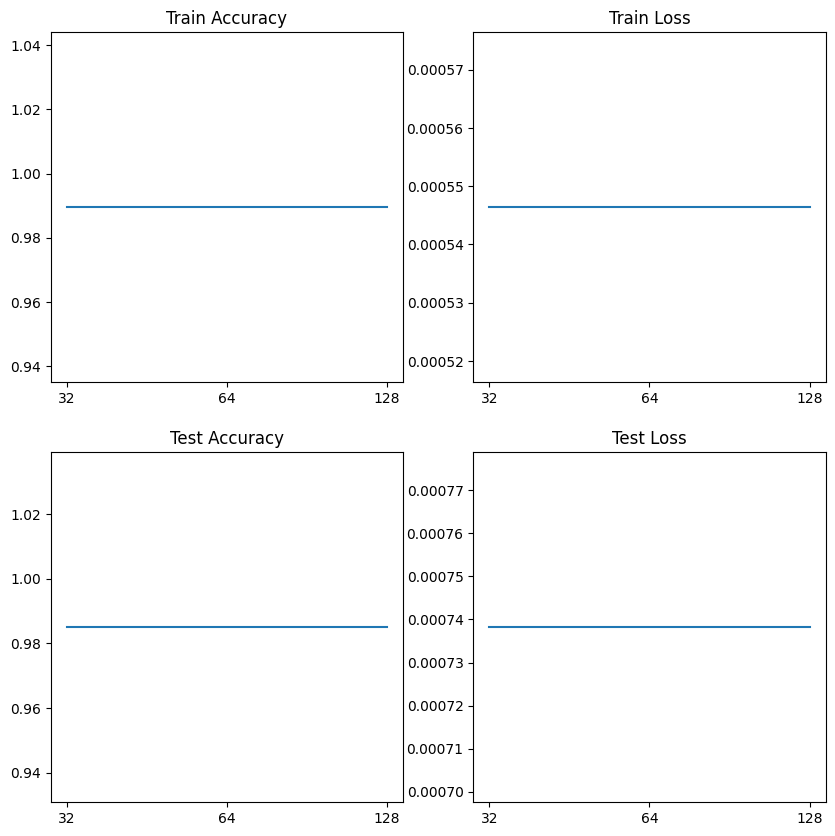

In [18]:
# plotting the results from the batch size
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# plotting the train accuracy
axs[0, 0].plot(list(results.keys()), [results[batch_size]['train_accuracy'] for batch_size in results.keys()])
axs[0, 0].set_title('Train Accuracy')
# plotting the train loss
axs[0, 1].plot(list(results.keys()), [results[batch_size]['train_loss'] for batch_size in results.keys()])
axs[0, 1].set_title('Train Loss')
# plotting the test accuracy
axs[1, 0].plot(list(results.keys()), [results[batch_size]['test_accuracy'] for batch_size in results.keys()])
axs[1, 0].set_title('Test Accuracy')
# plotting the test loss
axs[1, 1].plot(list(results.keys()), [results[batch_size]['test_loss'] for batch_size in results.keys()])
axs[1, 1].set_title('Test Loss')
plt.show()

#### Influence of Optimizer

In [19]:
# testing with different optimizers
results = {}
for optimizer in [[torch.optim.Adam, 0.001], [torch.optim.SGD, 0.1]]:
    classifier = Classifier()
    classifier.prepare_data(shuffle=False)
    classifier.create_model(model=LeNet(), optimizer=optimizer[0], criterion=nn.CrossEntropyLoss, lr=optimizer[1])
    train_accuracy, train_loss, test_accuracy, test_loss = classifier.train_model(n_epochs=5)
    results[str(optimizer[0].__name__)] = {'train_accuracy': train_accuracy, 'train_loss': train_loss, 'test_accuracy': test_accuracy, 'test_loss': test_loss}

loss=0.0150: 100%|██████████| 938/938 [00:19<00:00, 48.57it/s]



Test set: Avg. loss: 0.0014, Accuracy: 9724/10000 (97%)



loss=0.0088: 100%|██████████| 938/938 [00:18<00:00, 50.69it/s]



Test set: Avg. loss: 0.0009, Accuracy: 9824/10000 (98%)



loss=0.0044: 100%|██████████| 938/938 [00:18<00:00, 49.65it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9863/10000 (99%)



loss=0.0020: 100%|██████████| 938/938 [00:19<00:00, 48.66it/s]



Test set: Avg. loss: 0.0006, Accuracy: 9875/10000 (99%)



loss=0.0010: 100%|██████████| 938/938 [00:19<00:00, 48.86it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9850/10000 (98%)



loss=0.0205: 100%|██████████| 938/938 [00:17<00:00, 53.02it/s]



Test set: Avg. loss: 0.0015, Accuracy: 9684/10000 (97%)



loss=0.0138: 100%|██████████| 938/938 [00:18<00:00, 50.68it/s]



Test set: Avg. loss: 0.0010, Accuracy: 9788/10000 (98%)



loss=0.0105: 100%|██████████| 938/938 [00:17<00:00, 52.57it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9851/10000 (99%)



loss=0.0065: 100%|██████████| 938/938 [00:17<00:00, 52.93it/s]



Test set: Avg. loss: 0.0008, Accuracy: 9837/10000 (98%)



loss=0.0057: 100%|██████████| 938/938 [00:20<00:00, 46.82it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9837/10000 (98%)



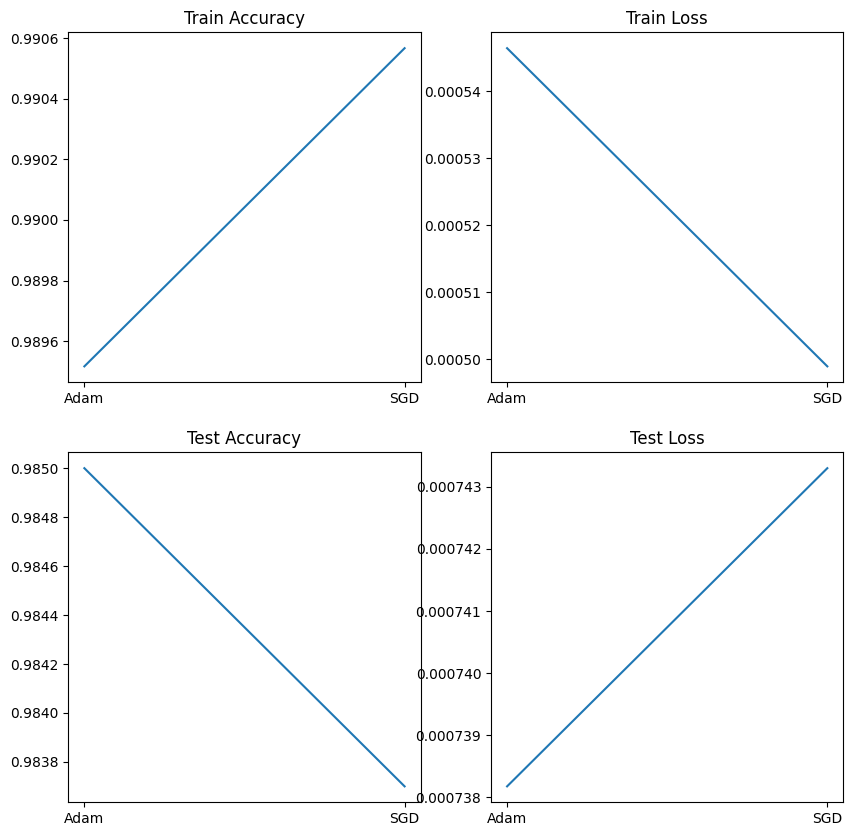

In [21]:
# plotting the results from the optimizers
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# plotting the train accuracy
axs[0, 0].plot(list(results.keys()), [results[optimizer]['train_accuracy'] for optimizer in results.keys()])
axs[0, 0].set_title('Train Accuracy')
# plotting the train loss
axs[0, 1].plot(list(results.keys()), [results[optimizer]['train_loss'] for optimizer in results.keys()])
axs[0, 1].set_title('Train Loss')
# plotting the test accuracy
axs[1, 0].plot(list(results.keys()), [results[optimizer]['test_accuracy'] for optimizer in results.keys()])
axs[1, 0].set_title('Test Accuracy')
# plotting the test loss
axs[1, 1].plot(list(results.keys()), [results[optimizer]['test_loss'] for optimizer in results.keys()])
axs[1, 1].set_title('Test Loss')
plt.show()

#### Observations

- Learning Rate
    - The learning rate is a hyperparameter that controls how much we are adjusting the weights of our network with respect to the loss gradient. The learning rate is a critical hyperparameter that can affect the performance of the model. A learning rate that is too small may result in a model that takes too long to train, whereas a learning rate that is too large may result in a model that learns too quickly and does not converge. The learning rate is a hyperparameter that can be tuned to improve the performance of the model.
    - In our case, we have only tested changing the learning rates of the Adam optimizer, which seems to perform best for a learning rate of 0.001. The model seems to perform poorly for learning rates of 0.0001 and 0.1. This is because the learning rate of 0.0001 is too small, and the model takes too long to train, whereas the learning rate of 0.1 is too large, and the model does not converge.
    - SGD is known to perform well with a learning rate of 0.1, comparable to Adam.

- Batch Size
    - There was no differnece at all seen in the performance of the model with different batch sizes. This is because the dataset is small and the model is simple, and the batch size does not affect the performance of the model. However, in general, a larger batch size can lead to faster training times, but it can also lead to overfitting. A smaller batch size can lead to slower training times, but it can also lead to better generalization.
    - Also the freezing of the random seed might have caused the same results for different batch sizes.

- Optimizer
    - There is no conclusive evidence to suggest that Adam performs better than SGD. However, Adam is known to perform better than SGD in most cases, and it is also known to be more robust to the choice of learning rate. In our case, Adam seems to perform better than SGD, but the difference is not significant. Yet, SGD has a better result on the test set, making any conclusion difficult.

### 2.3

The best results obtained in the SIFT-BoVW-SVM method was an accuracy of 75%, while the CNN model easily get an accuracy of 99% on various parameters. The CNN model is much better than the SIFT-BoVW-SVM model.

Several disparities exist between the two methodologies:

- In CNN, features are extracted in convolutional layers where kernels learn optimal values for feature extraction during training. Conversely, the classical ML model in question 1 employs SIFT for feature extraction, which lacks a learning component. Nevertheless, the first model utilizes k-means to extract the desired number of features for Bag of Visual Words, involving a degree of learning.

- The classical model's final classification employs an SVM, a linear classifier less effective for non-linearly separable data, which is often the case. This limitation can be mitigated using kernel methods, as demonstrated. In contrast, CNN is highly effective for non-linearly separable data, yielding significantly higher test accuracies.

Along with the above differnces in the methodology, the CNN method is much faster as compared to the clustering step involved in the SVM method making it more efficient.

### 2.4

#### New Model

In [51]:
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2)
        self.fc1 = nn.Linear(64*3*3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 64*3*3)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Training

In [52]:
classifier = Classifier()
classifier.prepare_data(shuffle=False)
classifier.create_model(model=CustomLeNet(), optimizer=torch.optim.Adam, criterion=nn.CrossEntropyLoss)
classifier.train_model(n_epochs=5)

loss=2.3190:   0%|          | 0/938 [00:00<?, ?it/s]

loss=0.0470: 100%|██████████| 938/938 [00:22<00:00, 41.75it/s]



Test set: Avg. loss: 0.0018, Accuracy: 9649/10000 (96%)



loss=0.0088: 100%|██████████| 938/938 [00:24<00:00, 38.31it/s]



Test set: Avg. loss: 0.0012, Accuracy: 9776/10000 (98%)



loss=0.0016: 100%|██████████| 938/938 [00:22<00:00, 40.88it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9850/10000 (98%)



loss=0.0006: 100%|██████████| 938/938 [00:22<00:00, 41.77it/s]



Test set: Avg. loss: 0.0006, Accuracy: 9881/10000 (99%)



loss=0.0012: 100%|██████████| 938/938 [00:24<00:00, 38.09it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9867/10000 (99%)



(0.9883666666666666,
 0.0005929304863958047,
 tensor(0.9867),
 0.0006693860162158671)

<!-- how does the performance of LeNet change if we double the numer of convolution layers -->
- On paper, the performance of LeNet will improve if we double the number of convolution layers. This is because the model will be able to learn more complex features from the input images. The number of parameters will also increase, which will help the model to learn more complex patterns in the data.
- But also the complexity of the model will increase, which will make the model more prone to overfitting. So, we need to be careful about the number of parameters in the model.
- The training here has shown that there is no significant and definite difference when compared to similar parameters training on the regular LeNet model. This might be because the model had already given a very high performance on the MNIST dataset and the increase in the number of convolution layers did not have a significant impact on the performance of the model.

### 2.5

In [58]:
# changing the train set size
results = {}
for train_size in [600, 1800, 6000, 18000, 60000]:
    classifier = Classifier()
    classifier.prepare_data(shuffle=False, train_size=train_size)
    classifier.create_model(model=LeNet(), optimizer=torch.optim.Adam, criterion=nn.CrossEntropyLoss)
    train_accuracy, train_loss, test_accuracy, test_loss = classifier.train_model(n_epochs=5)
    results[str(train_size)] = {'train_accuracy': train_accuracy, 'train_loss': train_loss, 'test_accuracy': test_accuracy, 'test_loss': test_loss}

loss=2.3462: 100%|██████████| 10/10 [00:00<00:00, 74.64it/s]



Test set: Avg. loss: 0.0350, Accuracy: 3620/10000 (36%)



loss=2.2451: 100%|██████████| 10/10 [00:00<00:00, 107.68it/s]



Test set: Avg. loss: 0.0315, Accuracy: 4562/10000 (46%)



loss=2.0458: 100%|██████████| 10/10 [00:00<00:00, 107.10it/s]



Test set: Avg. loss: 0.0241, Accuracy: 6411/10000 (64%)



loss=1.5584: 100%|██████████| 10/10 [00:00<00:00, 113.76it/s]



Test set: Avg. loss: 0.0168, Accuracy: 7148/10000 (71%)



loss=1.1704: 100%|██████████| 10/10 [00:00<00:00, 34.21it/s]



Test set: Avg. loss: 0.0127, Accuracy: 7570/10000 (76%)



loss=1.6992: 100%|██████████| 29/29 [00:00<00:00, 128.03it/s]



Test set: Avg. loss: 0.0290, Accuracy: 3627/10000 (36%)



loss=0.6649: 100%|██████████| 29/29 [00:00<00:00, 126.81it/s]



Test set: Avg. loss: 0.0172, Accuracy: 6007/10000 (60%)



loss=0.4880: 100%|██████████| 29/29 [00:00<00:00, 124.45it/s]



Test set: Avg. loss: 0.0104, Accuracy: 7845/10000 (78%)



loss=0.1839: 100%|██████████| 29/29 [00:00<00:00, 120.67it/s]



Test set: Avg. loss: 0.0089, Accuracy: 8196/10000 (82%)



loss=0.0909: 100%|██████████| 29/29 [00:00<00:00, 109.73it/s]



Test set: Avg. loss: 0.0070, Accuracy: 8639/10000 (86%)



loss=0.3616: 100%|██████████| 94/94 [00:00<00:00, 105.50it/s]



Test set: Avg. loss: 0.0157, Accuracy: 6585/10000 (66%)



loss=0.1974: 100%|██████████| 94/94 [00:00<00:00, 113.41it/s]



Test set: Avg. loss: 0.0060, Accuracy: 8748/10000 (87%)



loss=0.2567: 100%|██████████| 94/94 [00:00<00:00, 106.41it/s]



Test set: Avg. loss: 0.0045, Accuracy: 9044/10000 (90%)



loss=0.2062: 100%|██████████| 94/94 [00:00<00:00, 120.65it/s]



Test set: Avg. loss: 0.0041, Accuracy: 9132/10000 (91%)



loss=0.1554: 100%|██████████| 94/94 [00:00<00:00, 114.66it/s]



Test set: Avg. loss: 0.0041, Accuracy: 9141/10000 (91%)



loss=0.3549: 100%|██████████| 282/282 [00:02<00:00, 114.22it/s]



Test set: Avg. loss: 0.0126, Accuracy: 7286/10000 (73%)



loss=0.0838: 100%|██████████| 282/282 [00:02<00:00, 99.26it/s] 



Test set: Avg. loss: 0.0043, Accuracy: 9123/10000 (91%)



loss=0.0164: 100%|██████████| 282/282 [00:02<00:00, 100.02it/s]



Test set: Avg. loss: 0.0031, Accuracy: 9370/10000 (94%)



loss=0.0052: 100%|██████████| 282/282 [00:02<00:00, 104.41it/s]



Test set: Avg. loss: 0.0029, Accuracy: 9414/10000 (94%)



loss=0.0010: 100%|██████████| 282/282 [00:02<00:00, 108.15it/s]



Test set: Avg. loss: 0.0023, Accuracy: 9539/10000 (95%)



loss=0.0150: 100%|██████████| 938/938 [00:13<00:00, 71.65it/s]



Test set: Avg. loss: 0.0014, Accuracy: 9724/10000 (97%)



loss=0.0088: 100%|██████████| 938/938 [00:13<00:00, 70.53it/s]



Test set: Avg. loss: 0.0009, Accuracy: 9824/10000 (98%)



loss=0.0044: 100%|██████████| 938/938 [00:13<00:00, 69.90it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9863/10000 (99%)



loss=0.0020: 100%|██████████| 938/938 [00:13<00:00, 69.05it/s]



Test set: Avg. loss: 0.0006, Accuracy: 9875/10000 (99%)



loss=0.0010: 100%|██████████| 938/938 [00:14<00:00, 62.86it/s]



Test set: Avg. loss: 0.0007, Accuracy: 9850/10000 (98%)



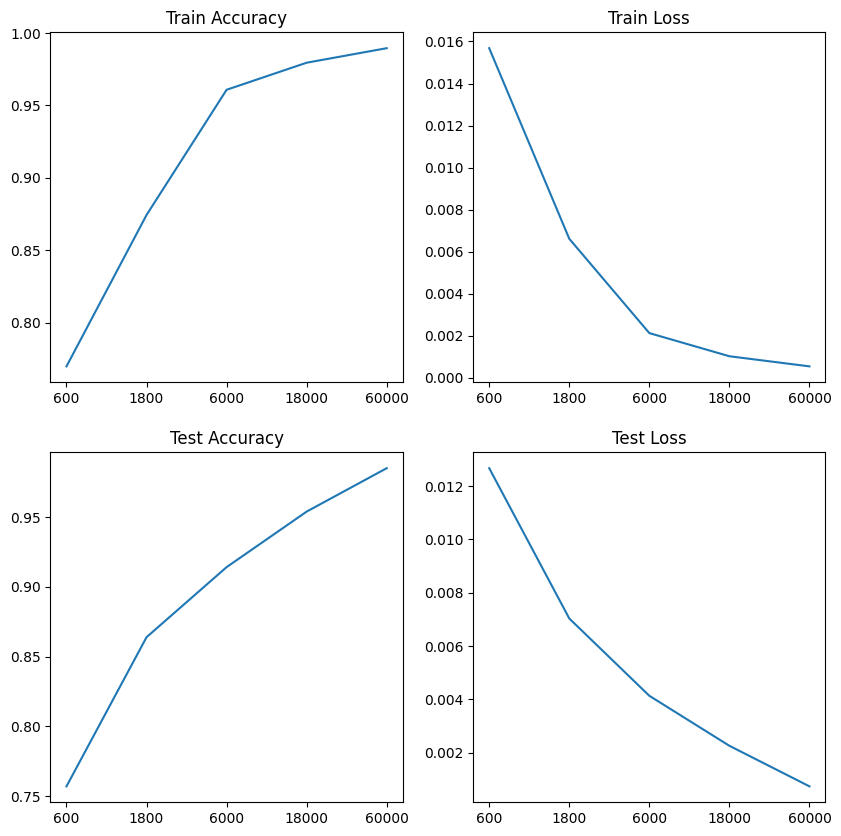

In [59]:
# plotting the results from the train set size
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# plotting the train accuracy
axs[0, 0].plot(list(results.keys()), [results[train_size]['train_accuracy'] for train_size in results.keys()])
axs[0, 0].set_title('Train Accuracy')
# plotting the train loss
axs[0, 1].plot(list(results.keys()), [results[train_size]['train_loss'] for train_size in results.keys()])
axs[0, 1].set_title('Train Loss')
# plotting the test accuracy
axs[1, 0].plot(list(results.keys()), [results[train_size]['test_accuracy'] for train_size in results.keys()])
axs[1, 0].set_title('Test Accuracy')
# plotting the test loss
axs[1, 1].plot(list(results.keys()), [results[train_size]['test_loss'] for train_size in results.keys()])
axs[1, 1].set_title('Test Loss')
plt.show()

- Increasing the number of images in the training set lets the model learn more about the data and helps the model to generalize better. This is because the model has more data to learn from, and it can learn more complex patterns in the data. This can help the model to perform better on the test set.
- A larger training set alse means on equal number of iterations, the larger dataset would generalise much better and overfitting is prevented for longer.

### 2.6

In [60]:
# Training ViT to compare with LeNet
results = {}
for train_size in [6000, 60000]:
    classifier = Classifier()
    classifier.prepare_data(shuffle=False, train_size=train_size)
    classifier.create_model(model=ViT((28, 28), 4, 100, 4, 2), optimizer=torch.optim.Adam, criterion=nn.CrossEntropyLoss)
    train_accuracy, train_loss, test_accuracy, test_loss = classifier.train_model(n_epochs=5)
    results[str(train_size)] = {'train_accuracy': train_accuracy, 'train_loss': train_loss, 'test_accuracy': test_accuracy, 'test_loss': test_loss}

loss=0.8358: 100%|██████████| 94/94 [00:06<00:00, 14.21it/s]



Test set: Avg. loss: 0.0171, Accuracy: 6065/10000 (61%)



loss=0.5585: 100%|██████████| 94/94 [00:06<00:00, 14.68it/s]



Test set: Avg. loss: 0.0092, Accuracy: 8070/10000 (81%)



loss=0.4646: 100%|██████████| 94/94 [00:06<00:00, 14.71it/s]



Test set: Avg. loss: 0.0069, Accuracy: 8595/10000 (86%)



loss=0.2102: 100%|██████████| 94/94 [00:06<00:00, 14.72it/s]



Test set: Avg. loss: 0.0062, Accuracy: 8729/10000 (87%)



loss=0.1311: 100%|██████████| 94/94 [00:07<00:00, 13.09it/s]



Test set: Avg. loss: 0.0048, Accuracy: 9017/10000 (90%)



loss=0.0605: 100%|██████████| 938/938 [01:09<00:00, 13.51it/s]



Test set: Avg. loss: 0.0032, Accuracy: 9388/10000 (94%)



loss=0.1052: 100%|██████████| 938/938 [01:25<00:00, 10.94it/s]



Test set: Avg. loss: 0.0027, Accuracy: 9471/10000 (95%)



loss=0.0287: 100%|██████████| 938/938 [01:22<00:00, 11.38it/s]



Test set: Avg. loss: 0.0020, Accuracy: 9599/10000 (96%)



loss=0.0521: 100%|██████████| 938/938 [01:25<00:00, 11.00it/s]



Test set: Avg. loss: 0.0020, Accuracy: 9594/10000 (96%)



loss=0.0535: 100%|██████████| 938/938 [01:19<00:00, 11.79it/s]



Test set: Avg. loss: 0.0018, Accuracy: 9637/10000 (96%)



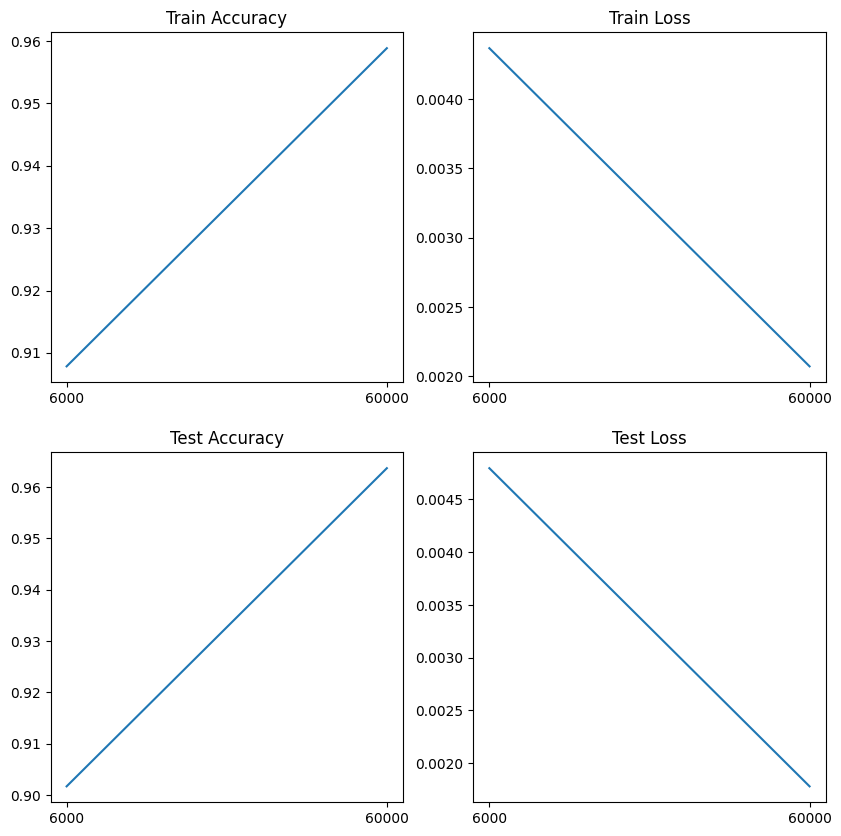

In [61]:
# plotting the results from the train set size
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# plotting the train accuracy
axs[0, 0].plot(list(results.keys()), [results[train_size]['train_accuracy'] for train_size in results.keys()])
axs[0, 0].set_title('Train Accuracy')
# plotting the train loss
axs[0, 1].plot(list(results.keys()), [results[train_size]['train_loss'] for train_size in results.keys()])
axs[0, 1].set_title('Train Loss')
# plotting the test accuracy
axs[1, 0].plot(list(results.keys()), [results[train_size]['test_accuracy'] for train_size in results.keys()])
axs[1, 0].set_title('Test Accuracy')
# plotting the test loss
axs[1, 1].plot(list(results.keys()), [results[train_size]['test_loss'] for train_size in results.keys()])
axs[1, 1].set_title('Test Loss')
plt.show()

- ViT gives very good performance on the MNIST dataset for image classification. The accuracies are decent, but compared to LeNet classification, the ViT model is not as good. This is because the ViT model is not designed for image classification, and it is not able to learn the complex patterns in the data as well as the LeNet model.
- The parameters used for the training were the best parameters found in the previous experiments for CNN, and the best parameters for ViT might improve the case a lot for ViT. But in this setting, the ViT does not perform well as compared to the LeNet model.
- Epochs were kept the same for both the models, and the ViT model might have needed more epochs to train and perform better. This might crucially affect the performance of the model, as ViT being a transformer model, needs more epochs to train and perform better, due to its complexity.